# In equilibrium fractionation from local snow

Equilibrium isotope-exchange reactions involve the redistribution of isotopes of an element among various species or compounds (in a strict sense, this only occurs in a closed, well-mixed system at chemical equilibrium). At isotopic equilibrium, the forward and backward reaction rates of any particular isotope are identical. This does not mean that the isotopic compositions of two compounds at equilibrium are identical, but only that the ratios of the different isotopes in each compound are constant for a particular temperature.

During equilibrium reactions, the heavier isotope generally preferentially accumulates in the species or compound with the higher oxidation state. For example, sulfate becomes enriched in 34S relative to sulfide (i.e., has a more positive various materials d34S value); consequently, the residual sulfide becomes depleted in various materials d34S. As a "rule of thumb," among different phases of the same compound or different species of the same element, the more dense the material, the more it tends to be enriched in the heavier isotope. For example, for the various phases of water, at equilibrium, d18OS > d18OL > d18OV. Also, the d13C and d18O values of CO2 < HCO3- < CaCO3.

During phase changes, the ratio of heavy to light isotopes in the molecules in the two phases changes. For example, as water vapor condenses in rain clouds (a process typically viewed as an equilibrium process), the heavier water isotopes (18O and 2H) become enriched in the liquid phase while the lighter isotopes (16O and 1H) remain in the vapor phase. In general, the higher the temperature, the less the difference between the equilibrium isotopic compositions of any two species (because the differences in ZPE between the species become smaller). The fractionation associated with the equilibrium exchange reaction between two substances A and B (i.e., the fractionation of A relative to B) can be expressed by use of the isotope fractionation factor a (alpha):

aA-B = RA / RB (Eq. 2.3)
where R = the ratio of the heavy isotope to the lighter isotope (i.e., D/H, 18O/16O, 34S/32S, etc.) in compounds A and B.
The value of such an equilibrium fractionation factor can be calculated on the basis of spectral data of the isotopic molecular species, at least for simple molecules. The a values generally differ by just a few percent from the equal-energy value of 1.00, except for exchange reactions involving hydrogen isotopes where a values may be as large as 4 at room temperature (see Friedman and O'Neil, 1977). The sign and magnitude of a are dependent on many factors, of which temperature is generally the most important. Other factors include chemical composition, crystal structure, and pressure.

The equilibrium fractionation factors (al-v) for the water liquid-vapor phase transition are 1.0098 and 1.084 at 20ºC and 1.0117 and 1.111 at 0ºC for 18O and 2H, respectively (Majoube, 1971). In both cases, al-v > 1, which means that the first phase (the liquid water) is "heavier" than the second phase (e.g., for al-v = 1.0098, the d18O of water is +9.8‰ higher than the d18O value of vapor at equilibrium). For the ice-water transition (0ºC), the values are 1.0035 and 1.0208, respectively (Arnason, 1969).

A useful equation that relates d values and fractionation factors is:

aA-B = (1000 + dA) / (1000 + dB) . (Eq. 2.4)

In [16]:
#Import modules:

import os
import netCDF4
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import glob
import datetime
import scipy as sp
import scipy.stats as stats

# Define directories

root = 'C:\\CiASOM\\PhD\\07.Manuscripts\\#2.Snow Surface\\TS Vapour and Snow\\Camilla\\'
picarro_directory = "iso_validated\\"
mto_directory = "POL\\validated\\"

In [17]:
### load METEOROLOGICAL data collected onboard of Polarsterm as a panda dataframe and mask big outliers ###

# Validated meteo data are stored as monthly files, list all file names
mto_monthly_files_list = glob.glob(root + mto_directory + "*1h*.txt")

mto_headers = pd.read_csv(mto_monthly_files_list[0], header=0, nrows=0).columns.tolist()
mto_units = pd.read_csv(mto_monthly_files_list[0], header=1, nrows=0).columns.tolist()

mto_dataset = pd.read_csv(mto_monthly_files_list[0], sep=";", header=[0], skiprows=[1], index_col=0, parse_dates=True)
for file in mto_monthly_files_list[1:]:
    data = pd.read_csv(file, sep=";", index_col=0, parse_dates=True, header=[0], skiprows=[1])
    mto_dataset = pd.concat([mto_dataset, data])

mto_dataset = mto_dataset.iloc[:, :]
mto_dataset = mto_dataset.astype(float)

# Add columns with year, month
mto_dataset['time'] = mto_dataset.index

mto_dataset['q_meteo'] = mto_dataset['q_meteo'].mask(mto_dataset['q_meteo'] < 0)
mto_dataset = mto_dataset.mask(mto_dataset['q_meteo'].isnull())

############################################################################################################################
############################################################################################################################
### load PICARRO atmospheric water isotope data as a panda dataframe and mask big outliers ###

# Picarro data are stored as monthly files, list all file names
picarro_monthly_files_list = glob.glob(root + picarro_directory + "*.txt")

picarro_headers = pd.read_csv(picarro_monthly_files_list[0], header=0, nrows=0).columns.tolist()
picarro_units = pd.read_csv(picarro_monthly_files_list[0], header=1, nrows=0).columns.tolist()

picarro_dataset = pd.read_csv(picarro_monthly_files_list[0], sep=";", header=[0], skiprows=[1], index_col=0, parse_dates=True)
for file in picarro_monthly_files_list[1:]:
    data = pd.read_csv(file, sep=";", index_col=0, parse_dates=True, header=[0], skiprows=[1])
    picarro_dataset = pd.concat([picarro_dataset, data])

picarro_dataset = picarro_dataset.iloc[:, :]
picarro_dataset = picarro_dataset.astype(float)

# Add columns with year, month
picarro_dataset['Time'] = picarro_dataset.index

# MASK out suspiciously high/low values (NAs)
picarro_dataset = picarro_dataset.mask(picarro_dataset['d-excess'] < -50)
picarro_dataset = picarro_dataset.mask(picarro_dataset['q'] > 10)

In [18]:
# ALPHA EQUILIBRIUM FRACTIONATION (Majoube 1971)
################################################

a = mto_dataset.loc['2019-10-01':'2020-09-30', 'temperature'].min()
b = mto_dataset.loc['2019-10-01':'2020-09-30', 'temperature'].max()
# print(round(a),round(b))

Temp = []
alpha_mj_O = []
alpha_mj_D = []
alpha_el_O = []
alpha_el_D = []

for T in range(round(a) - 1, round(b) + 1):
    Temp.append(T)

    ############ Solid phase transition ########################################################
    alpha_mj_18O = np.exp((11.839) / (T + 273.15) - (28.224 * 10 ** (-3)))  # l'equilibre de O18 de Majoube 1971
    alpha_mj_O.append(alpha_mj_18O)

    alpha_mj_DH = np.exp((16288.0) / (T + 273.15) ** 2 - (9.34 * 10 ** (-2)))  # l'equilibre de D de Majoube 1971
    alpha_mj_D.append(alpha_mj_DH)

    ############ Solid phase transition #########################################################

    alpha_el_18O = np.exp(0.0831 - 49.192 / (T + 273.15) + 8312.5 / (T + 273.15) ** 2)  # Coefficient de fractionnement: l'equilibre de O18 de Ellehoj 2013
    alpha_el_O.append(alpha_el_18O)

    alpha_el_DH = np.exp(0.2133 - 203.10 / (T + 273.15) + 48888 / (T + 273.15) ** 2) - 0.02  # Coefficient de fractionnement:l'equilibre de D de Ellehoj 2013
    alpha_el_D.append(alpha_el_DH)

alpha_equilibrium = pd.DataFrame({'temperature': Temp, 'alpha_mj_O': alpha_mj_O, 'alpha_mj_D': alpha_mj_D})


# COMPUTE THEORETICAL WATER VAPOUR in EQUILIBRIUM WITH SNOW -21permil
####################################################################

# ALPHAs-v = R-snow / R-vapor
# delta-snow = (R-snow / R-vsmow - 1) * 1000

R18O_vsmow = 2005.20  # ppm
RD_vsmow = 155.75  # ppm

###############################################################
delta18O_snow = -41  # permil
R18O_snow = (delta18O_snow / 1000 + 1) * R18O_vsmow
R18O_vap = R18O_snow / np.array(alpha_mj_O)
delta18O_vap = (R18O_vap / R18O_vsmow - 1) * 1000

###############################################################
deltaD_snow = delta18O_snow * 8  # permil
RD_snow = (deltaD_snow / 1000 + 1) * RD_vsmow
RD_vap = RD_snow / np.array(alpha_mj_D)
deltaD_vap = (RD_vap / RD_vsmow - 1) * 1000


###############################################################
# Save in dataframe
synthetic_e_vapor = pd.DataFrame()
synthetic_e_vapor['temperature'] = Temp
synthetic_e_vapor['d18O'] = delta18O_vap
synthetic_e_vapor['dD'] = deltaD_vap
synthetic_e_vapor['d-excess'] = np.array(deltaD_vap) - 8 * np.array(delta18O_vap)

In [19]:
# ALPHA KINETIC FRACTIONATION IN SUPER SATURATED CONDITIONS (Jouzel and Merlivat 1984)
######################################################################################

Temp = []
alpha_k_O = []
alpha_k_D = []

for T in alpha_equilibrium['temperature']:
    Temp.append(T)
    temp = str(T)
    alpha_equilib_O = alpha_equilibrium.query('temperature == ' + temp)['alpha_mj_O']
    alpha_equilib_D = alpha_equilibrium.query('temperature == ' + temp)['alpha_mj_D']

    Si = 0.05 + 0.906 ** (-0.008 * T)
    Si = 1 - 0.0066 * T
    alpha_kinetic_O = Si / ((alpha_equilib_O) * (0.9723 / 0.9755) * (Si - 1) + 1)
    alpha_kinetic_D = Si / ((alpha_equilib_D) * (0.9723 / 0.9755) * (Si - 1) + 1)
    alpha_k_O.append(alpha_kinetic_O)
    alpha_k_D.append(alpha_kinetic_D)

alpha_kinetic = pd.DataFrame({'temperature': Temp, 'alpha_k_O': alpha_k_O, 'alpha_k_D': alpha_k_D})


# COMPUTE THEORETICAL WATER VAPOUR in EQUILIBRIUM+KINETIC WITH SNOW -21 permil
####################################################################

R18O_vsmow = 2005.20  # ppm
RD_vsmow = 155.75  # ppm

###############################################################
delta18O_snow = -41  # permil
R18O_snow = (delta18O_snow / 1000 + 1) * R18O_vsmow

alpha = alpha_equilibrium['alpha_mj_O'] * alpha_kinetic['alpha_k_O']
R18O_k_vap = R18O_snow / alpha
delta18O_k_vap = (R18O_k_vap / R18O_vsmow - 1) * 1000

###############################################################
deltaD_snow = delta18O_snow * 8  # permil
RD_snow = (deltaD_snow / 1000 + 1) * RD_vsmow

alpha = alpha_equilibrium['alpha_mj_D'] * alpha_kinetic['alpha_k_D']
RD_k_vap = RD_snow / alpha
deltaD_k_vap = (RD_k_vap / RD_vsmow - 1) * 1000

###############################################################
# Save in dataframe
synthetic_k_vapor = pd.DataFrame()
synthetic_k_vapor['temperature'] = Temp
synthetic_k_vapor['d18O'] = delta18O_k_vap
synthetic_k_vapor['dD'] = deltaD_k_vap
synthetic_k_vapor['d-excess'] = np.array(deltaD_k_vap) - 8 * np.array(delta18O_k_vap)

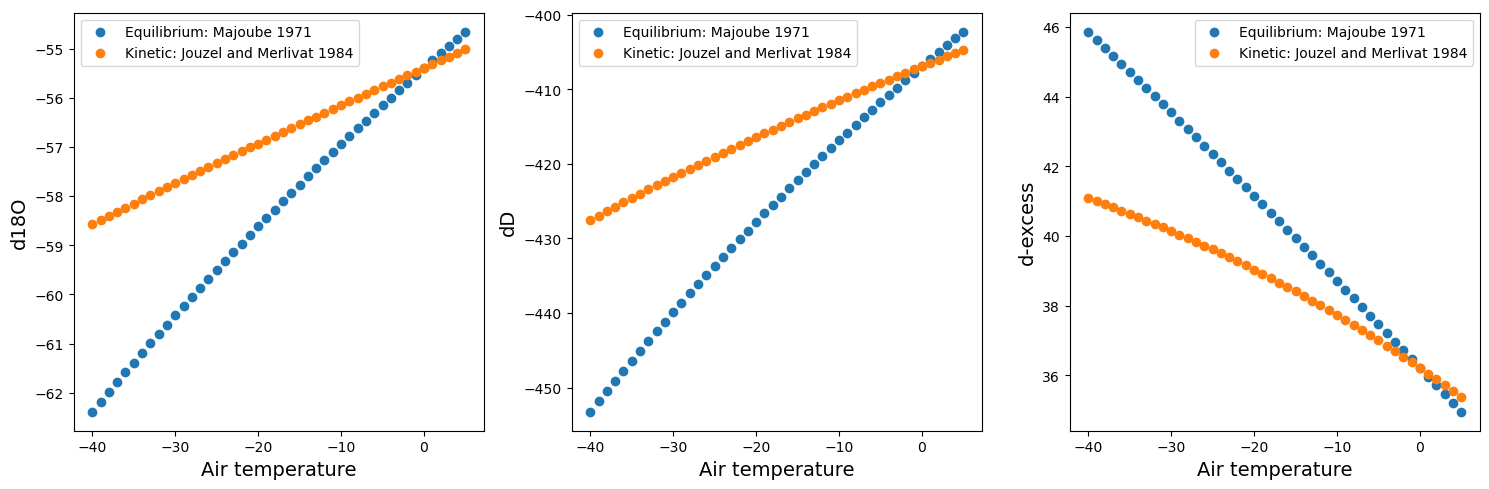

In [29]:
###############################################################
# PLOT
fig, plot = plt.subplots(1, 3, figsize=(15, 5))

plot[0].scatter(synthetic_e_vapor['temperature'], synthetic_e_vapor['d18O'], label="Equilibrium: Majoube 1971")
plot[0].scatter(synthetic_k_vapor['temperature'], synthetic_k_vapor['d18O'], label="Kinetic: Jouzel and Merlivat 1984")
plot[0].set_xlabel("Air temperature", size=14)
plot[0].set_ylabel("d18O", size=14)
plot[0].legend(loc="best")

plot[1].scatter(synthetic_e_vapor['temperature'], synthetic_e_vapor['dD'], label="Equilibrium: Majoube 1971")
plot[1].scatter(synthetic_k_vapor['temperature'], synthetic_k_vapor['dD'], label="Kinetic: Jouzel and Merlivat 1984")
plot[1].set_xlabel("Air temperature", size=14)
plot[1].set_ylabel("dD", size=14)
plot[1].legend(loc="best")

plot[2].scatter(synthetic_e_vapor['temperature'], synthetic_e_vapor['d-excess'], label="Equilibrium: Majoube 1971")
plot[2].scatter(synthetic_k_vapor['temperature'], synthetic_k_vapor['d-excess'], label="Kinetic: Jouzel and Merlivat 1984")
plot[2].set_xlabel("Air temperature", size=14)
plot[2].set_ylabel("d-excess", size=14)
plot[2].legend(loc="best")

plt.tight_layout()

plt.savefig('C:/CiASOM/PhD/07.Manuscripts/#2.Snow Surface/TS Vapour and Snow/Camilla/plot_1.jpg', dpi=300)

plt.show()

C:\Users\mardakan\AppData\Local\Temp\ipykernel_15572\3993497497.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 2, index + 1)


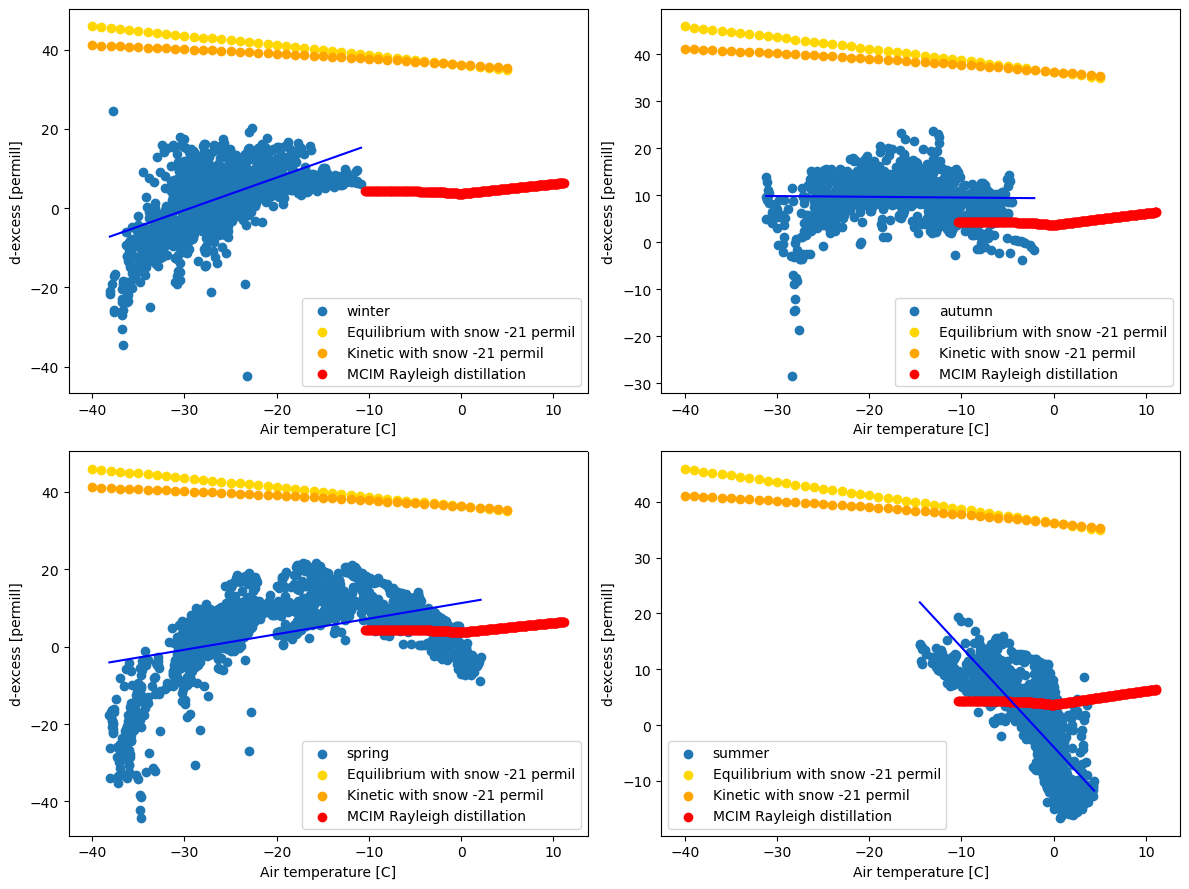

In [30]:
# IMPORT MCIM OUTPUT
mcim = pd.read_csv("C:/CiASOM/PhD/07.Manuscripts/#2.Snow Surface/TS Vapour and Snow/Camilla/4.ECHAM6_wiso/MCIM_for_Camilla_summer.csv", encoding='latin-1', on_bad_lines='skip')
mcim['d-excess'] = mcim['dDvap'] - 8 * mcim['d18Ovap']

# SEASONAL SCATTERPLOTS ISO-TEMP
############################
intervals = [
    ['2019-12-01', '2020-02-28'],
    ['2019-10-01', '2019-11-30'],
    ['2020-03-01', '2020-05-31'],
    ['2020-06-01', '2020-09-30']
]
season = ['winter', 'autumn', 'spring', 'summer']

plt.figure(figsize=(12, 9))
plt.subplots_adjust(hspace=0.5)
plt.title("Seasonal observations and isotope models", fontsize=18, y=0.95)

for index, interval in enumerate(intervals):
    ax = plt.subplot(2, 2, index + 1)

    t = picarro_dataset.loc[interval[0]:interval[1]].index
    x = picarro_dataset.loc[interval[0]:interval[1], 'd-excess']
    y = mto_dataset.loc[interval[0]:interval[1], 'temperature']
    df = pd.DataFrame({'Time': t, 'Water vapour delta-18O [permil]': x, 'Air Temperature [deg C]': y})
    df1 = df.dropna()

    # observations
    ax.scatter(df1['Air Temperature [deg C]'], df1['Water vapour delta-18O [permil]'], label=season[index])
    # Equilibrium:Majoube 1971
    ax.scatter(synthetic_e_vapor['temperature'], synthetic_e_vapor['d-excess'], color='gold',
               label='Equilibrium with snow -21 permil')
    # Kinetic:Jouzel and Merlivat 1984
    ax.scatter(synthetic_k_vapor['temperature'], synthetic_k_vapor['d-excess'], color='orange',
               label='Kinetic with snow -21 permil')
    # MCIM model
    ax.scatter(mcim['Ts'], mcim['d-excess'], color='red', label='MCIM Rayleigh distillation')

    ax.legend(loc='best')
    ax.set_xlabel('Air temperature [C]')
    ax.set_ylabel('d-excess [permill]')

    slope, intercept = np.polyfit(df1['Air Temperature [deg C]'], df1['Water vapour delta-18O [permil]'], 1)
    x_line = np.linspace(np.min(df1['Air Temperature [deg C]']), np.max(df1['Air Temperature [deg C]']), 100)
    y_line = np.polyval([slope, intercept], x_line)
    ax.plot(x_line, y_line, color='blue')

plt.tight_layout()

plt.savefig('C:/CiASOM/PhD/07.Manuscripts/#2.Snow Surface/TS Vapour and Snow/Camilla/plot_2.jpg', dpi=300)

plt.show()

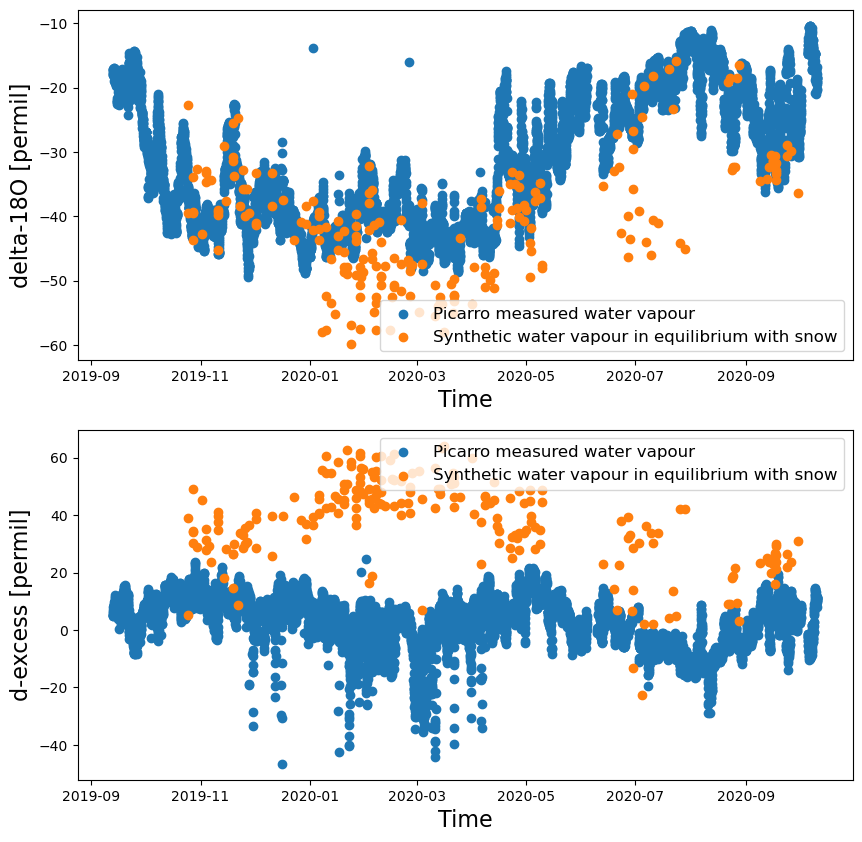

In [22]:
# SYNTHETIC VAPOR GENERATED IN EQUILIBRIUM BY sublimation FROM MEASURED SNOW
#########################################################################################

dfs = pd.read_csv('C:/CiASOM/PhD/07.Manuscripts/#2.Snow Surface/TS Vapour and Snow/Snow_Surface.csv', index_col=0, parse_dates=True, encoding='latin1')
dfs['Time'] = dfs.index

delta18O_snow = dfs['d18O']
deltaD_snow = dfs['dD']
air_temp = dfs['Air_Temp']

delta18O_vap = []
deltaD_vap = []
synthetic_vapor = pd.DataFrame()

for index, temp in enumerate(air_temp):

    alpha_equilib_18O = np.exp((11.839) / (temp + 273.15) - (28.224 * 10 ** (-3)))
    alpha_equilib_D = np.exp((16288.0) / (temp + 273.15) ** 2 - (9.34 * 10 ** (-2)))

    Si = 1 - 0.002 * T
    Si = 0.05 + 0.906 ** (-0.008 * T)
    Si = 0.99 - 0.006 * T

    alpha_kinetic_18O = Si / ((alpha_equilib_18O) * (0.9723 / 0.9755) * (Si - 1) + 1)
    alpha_kinetic_D = Si / ((alpha_equilib_D) * (0.9723 / 0.9755) * (Si - 1) + 1)

    R18O_snow = (delta18O_snow[index] / 1000 + 1) * R18O_vsmow
    R18O_vap = R18O_snow / (alpha_equilib_18O * alpha_kinetic_18O)
    delta18O_vap.append((R18O_vap / R18O_vsmow - 1) * 1000)

    RD_snow = (deltaD_snow[index] / 1000 + 1) * RD_vsmow
    RD_vap = RD_snow / (alpha_equilib_D * alpha_kinetic_18O)
    deltaD_vap.append((RD_vap / RD_vsmow - 1) * 1000)

synthetic_vapor['Time'] = dfs.index
synthetic_vapor['d18O'] = delta18O_vap
synthetic_vapor['dD'] = deltaD_vap
synthetic_vapor['d-excess'] = np.array(deltaD_vap) - 8 * np.array(delta18O_vap)
synthetic_vapor.set_index(synthetic_vapor['Time'])

# PLOT SYNTHETIC VAPOR GENERATED IN EQUILIBRIUM BY sublimation FROM MEASURED SNOW
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

axes[0].scatter(picarro_dataset['Time'], picarro_dataset['d18O'], label='Picarro measured water vapour')
axes[0].scatter(synthetic_vapor['Time'], synthetic_vapor['d18O'], label='Synthetic water vapour in equilibrium with snow')
axes[0].set_ylabel('delta-18O [permil]', fontsize=16)
axes[0].set_xlabel('Time', fontsize=16)
axes[0].legend(loc='best', fontsize=12)

axes[1].scatter(picarro_dataset['Time'], picarro_dataset['d-excess'], label='Picarro measured water vapour')
axes[1].scatter(synthetic_vapor['Time'], synthetic_vapor['d-excess'], label='Synthetic water vapour in equilibrium with snow')
axes[1].set_ylabel('d-excess [permil]', fontsize=16)
axes[1].set_xlabel('Time', fontsize=16)
axes[1].legend(loc='best', fontsize=12)

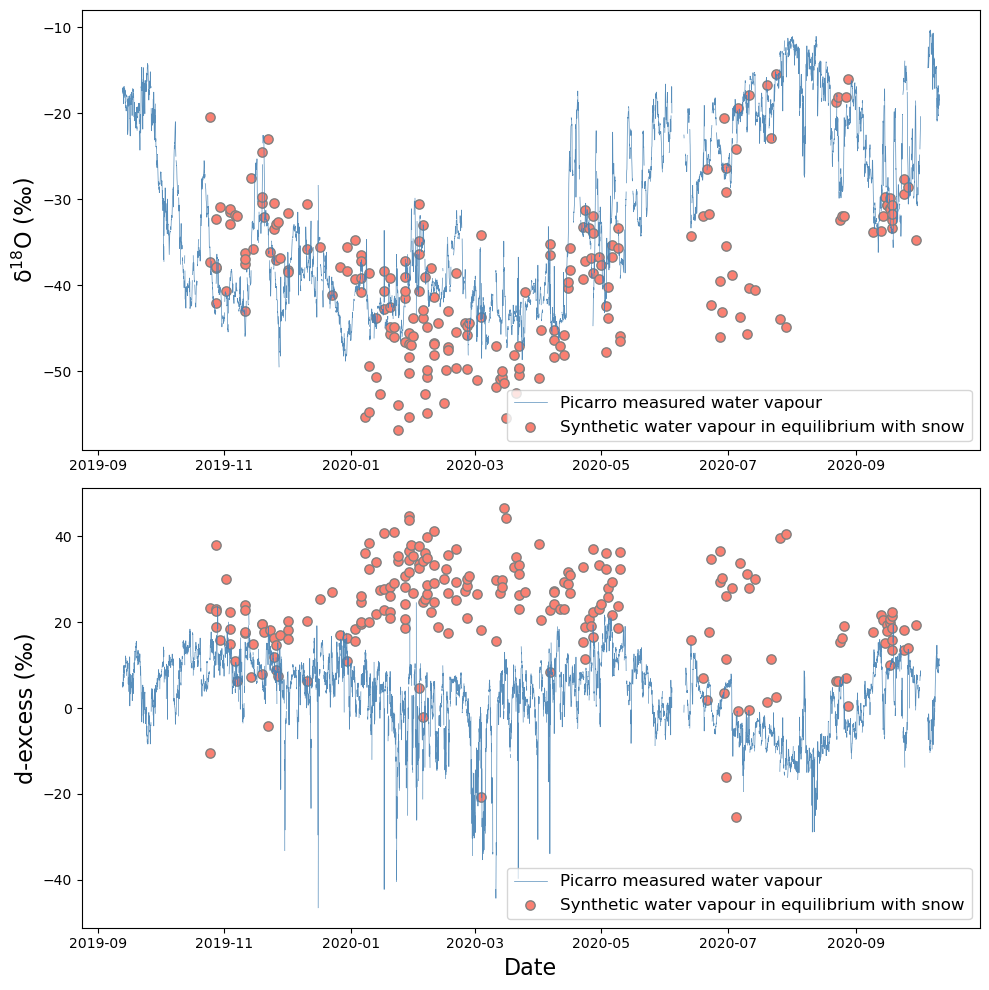

In [31]:
# SYNTHETIC VAPOR GENERATED IN EQUILIBRIUM BY sublimation FROM MEASURED SNOW
#########################################################################################

dfs = pd.read_csv('C:/CiASOM/PhD/07.Manuscripts/#2.Snow Surface/TS Vapour and Snow/Snow_Surface.csv', index_col=0, parse_dates=True, encoding='latin1')
dfs['Time'] = dfs.index

delta18O_snow = dfs['d18O']
deltaD_snow = dfs['dD']
air_temp = dfs['Air_Temp']

delta18O_vap = []
deltaD_vap = []
synthetic_vapor = pd.DataFrame()

for index, temp in enumerate(air_temp):
    alpha_equilib_18O = np.exp((11.839) / (temp + 273.15) - (28.224 * 10 ** (-3)))
    alpha_equilib_D = np.exp((16288.0) / (temp + 273.15) ** 2 - (9.34 * 10 ** (-2)))

    Si = 1 - 0.002 * temp
    Si = 0.05 + 0.906 ** (-0.008 * temp)
    Si = 0.99 - 0.006 * temp

    alpha_kinetic_18O = Si / ((alpha_equilib_18O) * (0.9723 / 0.9755) * (Si - 1) + 1)
    alpha_kinetic_D = Si / ((alpha_equilib_D) * (0.9723 / 0.9755) * (Si - 1) + 1)

    R18O_snow = (delta18O_snow[index] / 1000 + 1) * R18O_vsmow
    R18O_vap = R18O_snow / (alpha_equilib_18O * alpha_kinetic_18O)
    delta18O_vap.append((R18O_vap / R18O_vsmow - 1) * 1000)

    RD_snow = (deltaD_snow[index] / 1000 + 1) * RD_vsmow
    RD_vap = RD_snow / (alpha_equilib_D * alpha_kinetic_18O)
    deltaD_vap.append((RD_vap / RD_vsmow - 1) * 1000)

synthetic_vapor['Time'] = dfs.index
synthetic_vapor['d18O'] = delta18O_vap
synthetic_vapor['dD'] = deltaD_vap
synthetic_vapor['d-excess'] = np.array(deltaD_vap) - 8 * np.array(delta18O_vap)
synthetic_vapor.set_index(synthetic_vapor['Time'])

# PLOT SYNTHETIC VAPOR GENERATED IN EQUILIBRIUM BY sublimation FROM MEASURED SNOW
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

axes[0].plot(picarro_dataset['Time'], picarro_dataset['d18O'], label='Picarro measured water vapour', linestyle='-', color='steelblue', alpha=0.9, linewidth=0.5)
axes[0].scatter(synthetic_vapor['Time'], synthetic_vapor['d18O'], label='Synthetic water vapour in equilibrium with snow', color='salmon', s=45, edgecolor='grey')
axes[0].set_ylabel("δ$^{18}$O (‰)", fontsize=16)
#axes[0].set_xlabel('Date', fontsize=16)
axes[0].legend(loc='best', fontsize=12)

axes[1].plot(picarro_dataset['Time'], picarro_dataset['d-excess'], label='Picarro measured water vapour', linestyle='-', color='steelblue', alpha=0.9, linewidth=0.5)
axes[1].scatter(synthetic_vapor['Time'], synthetic_vapor['d-excess'], label='Synthetic water vapour in equilibrium with snow', color='salmon', s=45, edgecolor='grey')
axes[1].set_ylabel("d-excess (‰)", fontsize=16)
axes[1].set_xlabel('Date', fontsize=16)
axes[1].legend(loc='best', fontsize=12)

plt.tight_layout()

plt.savefig('C:/CiASOM/PhD/07.Manuscripts/#2.Snow Surface/TS Vapour and Snow/Camilla/Vapour_mes_syn.jpg', dpi=300)

plt.show()

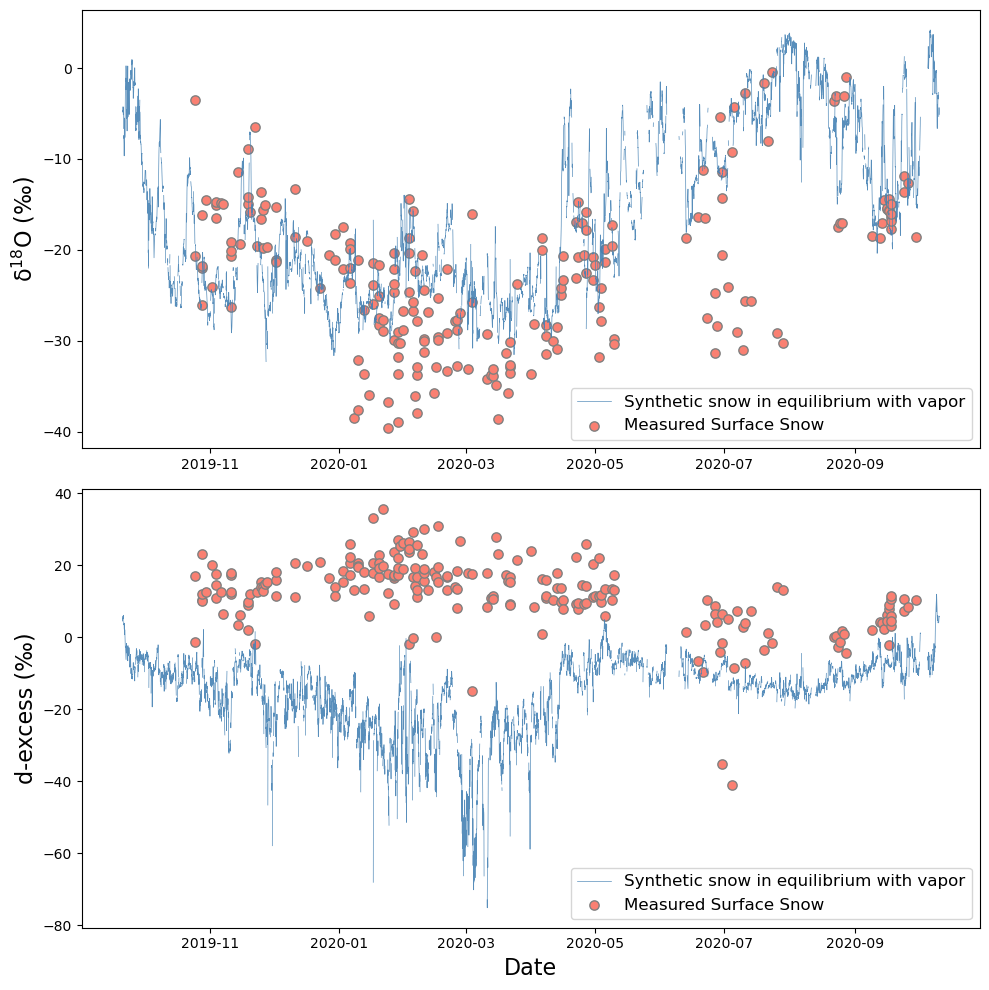

In [34]:
# SYNTHETIC SNOW GENERATED IN EQUILIBRIUM condensation FROM MEASURED VAPOR
################################################################################

delta18O_vap = picarro_dataset['d18O']
deltaD_vap = picarro_dataset['dHDO']
air_temp = mto_dataset['temperature']

delta18O_snow = []
deltaD_snow = []
synthetic_snow = pd.DataFrame()

for index, temp in enumerate(air_temp):
    
    alpha_equilib_18O = np.exp((11.839) / (temp + 273.15) - (28.224 * 10 ** (-3)))
    alpha_equilib_D = np.exp((16288.0) / (temp + 273.15) ** 2 - (9.34 * 10 ** (-2)))
    
    Si = 1 - 0.002 * temp
    Si = 0.05 + 0.906 ** (-0.008 * temp)
    Si = 0.99 - 0.006 * temp
    
    alpha_kinetic_18O = Si / ((alpha_equilib_18O) * (0.9723 / 0.9755) * (Si - 1) + 1)
    alpha_kinetic_D = Si / ((alpha_equilib_D) * (0.9723 / 0.9755) * (Si - 1) + 1)
    
    R18O_vap = (delta18O_vap[index] / 1000 + 1) * R18O_vsmow
    R18O_snow = R18O_vap * (alpha_equilib_18O * alpha_kinetic_18O)
    delta18O_snow.append((R18O_snow / R18O_vsmow - 1) * 1000)
    
    RD_vap = (deltaD_vap[index] / 1000 + 1) * RD_vsmow
    RD_snow = RD_vap * (alpha_equilib_D * alpha_kinetic_D)
    deltaD_snow.append((RD_snow / RD_vsmow - 1) * 1000)
    
synthetic_snow['Time'] = picarro_dataset['Time']
synthetic_snow['d18O'] = delta18O_snow
synthetic_snow['dD'] = deltaD_snow
synthetic_snow['d-excess'] = synthetic_snow['dD'] - 8 * synthetic_snow['d18O']
synthetic_snow.set_index(synthetic_snow['Time'])


# PLOT SYNTHETIC SNOW GENERATED IN EQUILIBRIUM BY condensation FROM MEASURED VAPOR
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

axes[0].plot(synthetic_snow['Time'], synthetic_snow['d18O'], linestyle='-', label='Synthetic snow in equilibrium with vapor', color='steelblue', alpha=0.9, linewidth=0.5)
axes[0].scatter(dfs['Time'], dfs['d18O'], label='Measured Surface Snow', color='salmon', s=45, edgecolor='grey')
axes[0].set_ylabel("δ$^{18}$O (‰)", fontsize=16)
#axes[0].set_xlabel('Date', fontsize=16)
axes[0].legend(loc='best', fontsize=12)


axes[1].plot(synthetic_snow['Time'], synthetic_snow['d-excess'], linestyle='-', label='Synthetic snow in equilibrium with vapor', color='steelblue', alpha=0.9, linewidth=0.5)
axes[1].scatter(dfs['Time'], dfs['d_excess'], label='Measured Surface Snow', color='salmon', s=45, edgecolor='grey')
axes[1].set_ylabel("d-excess (‰)", fontsize=16)
axes[1].set_xlabel('Date', fontsize=16)
axes[1].legend(loc='best', fontsize=12)

plt.tight_layout()

plt.savefig('C:/CiASOM/PhD/07.Manuscripts/#2.Snow Surface/TS Vapour and Snow/Camilla/Snow_mes_syn.jpg', dpi=300)

plt.show()

NameError: name 'picarro_dataset' is not defined

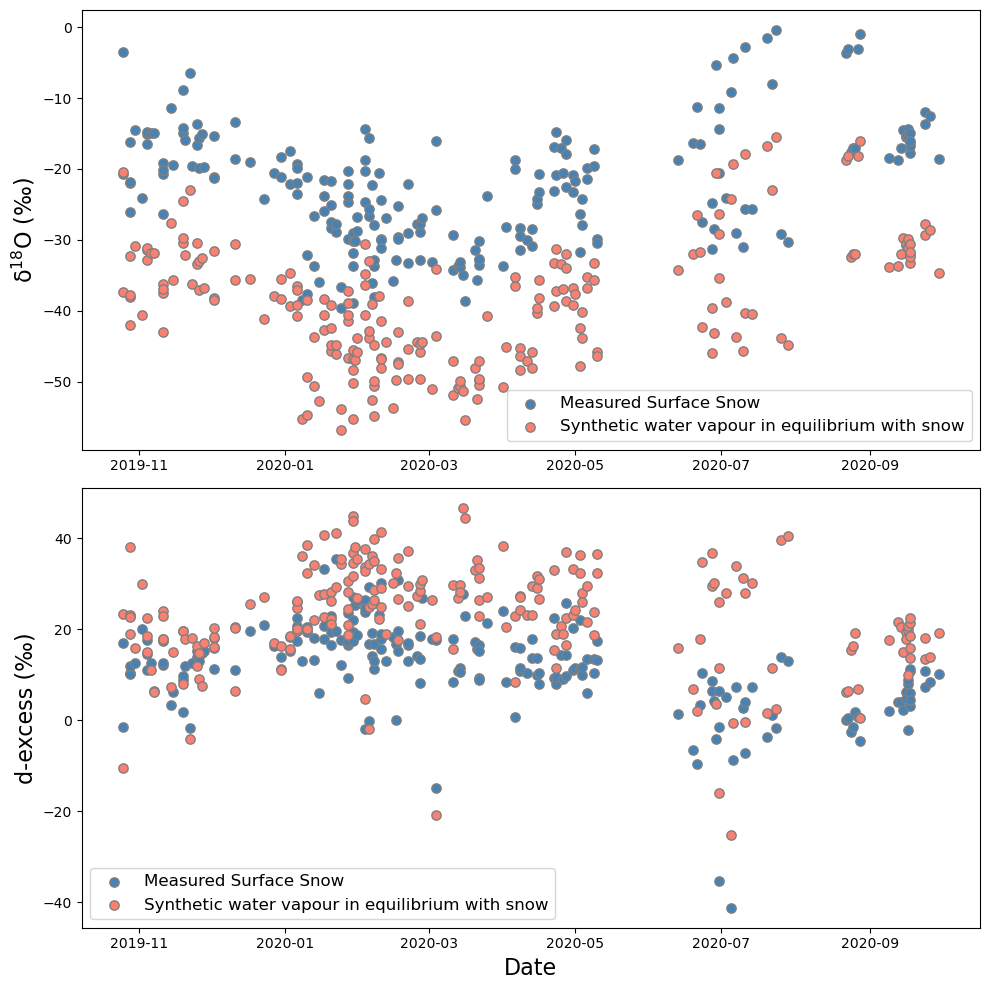

In [33]:
# SYNTHETIC VAPOR GENERATED IN EQUILIBRIUM BY sublimation FROM MEASURED SNOW
#########################################################################################

dfs = pd.read_csv('C:/CiASOM/PhD/07.Manuscripts/#2.Snow Surface/TS Vapour and Snow/Snow_Surface.csv', index_col=0, parse_dates=True, encoding='latin1')
dfs['Time'] = dfs.index

delta18O_snow = dfs['d18O']
deltaD_snow = dfs['dD']
air_temp = dfs['Air_Temp']

delta18O_vap = []
deltaD_vap = []
synthetic_vapor = pd.DataFrame()

for index, temp in enumerate(air_temp):
    alpha_equilib_18O = np.exp((11.839)/(temp+273.15) - (28.224*10**(-3)))
    alpha_equilib_D = np.exp((16288.0)/(temp+273.15)**2 - (9.34*10**(-2)))

    Si = 1 - 0.002 * temp
    Si = 0.05 + 0.906**(-0.008 * temp)
    Si = 0.99 - 0.006 * temp

    alpha_kinetic_18O = Si / ((alpha_equilib_18O) * (0.9723/0.9755) * (Si-1) + 1)
    alpha_kinetic_D = Si / ((alpha_equilib_D) * (0.9723/0.9755) * (Si-1) + 1)

    R18O_snow = (delta18O_snow[index]/1000 + 1) * R18O_vsmow
    R18O_vap = R18O_snow / (alpha_equilib_18O * alpha_kinetic_18O)
    delta18O_vap.append((R18O_vap/R18O_vsmow - 1) * 1000)

    RD_snow = (deltaD_snow[index]/1000 + 1) * RD_vsmow
    RD_vap = RD_snow / (alpha_equilib_D * alpha_kinetic_18O)
    deltaD_vap.append((RD_vap/RD_vsmow - 1) * 1000)

synthetic_vapor['Time'] = dfs.index
synthetic_vapor['d18O'] = delta18O_vap
synthetic_vapor['dD'] = deltaD_vap
synthetic_vapor['d-excess'] = np.array(deltaD_vap) - 8 * np.array(delta18O_vap)
synthetic_vapor.set_index(synthetic_vapor['Time'])

# PLOT SYNTHETIC VAPOR GENERATED IN EQUILIBRIUM BY sublimation FROM MEASURED SNOW
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

axes[0].scatter(dfs['Time'], dfs['d18O'], label='Measured Surface Snow', color='steelblue', s=45, edgecolor='grey')
axes[0].scatter(synthetic_vapor['Time'], synthetic_vapor['d18O'], label='Synthetic water vapour in equilibrium with snow', color='salmon', s=45, edgecolor='grey')
axes[0].set_ylabel("δ$^{18}$O (‰)", fontsize=16)
#axes[0].set_xlabel('Date', fontsize=16)
axes[0].legend(loc='best', fontsize=12)

axes[1].scatter(dfs['Time'], dfs['d_excess'], label='Measured Surface Snow', color='steelblue', s=45, edgecolor='grey')
axes[1].scatter(synthetic_vapor['Time'], synthetic_vapor['d-excess'], label='Synthetic water vapour in equilibrium with snow', color='salmon', s=45, edgecolor='grey')
axes[1].set_ylabel("d-excess (‰)", fontsize=16)
axes[1].set_xlabel('Date', fontsize=16)
axes[1].legend(loc='best', fontsize=12)

plt.tight_layout()

plt.savefig('C:/CiASOM/PhD/07.Manuscripts/#2.Snow Surface/TS Vapour and Snow/Camilla/Snow_mes_Vapour_syn.jpg', dpi=300)

plt.show()

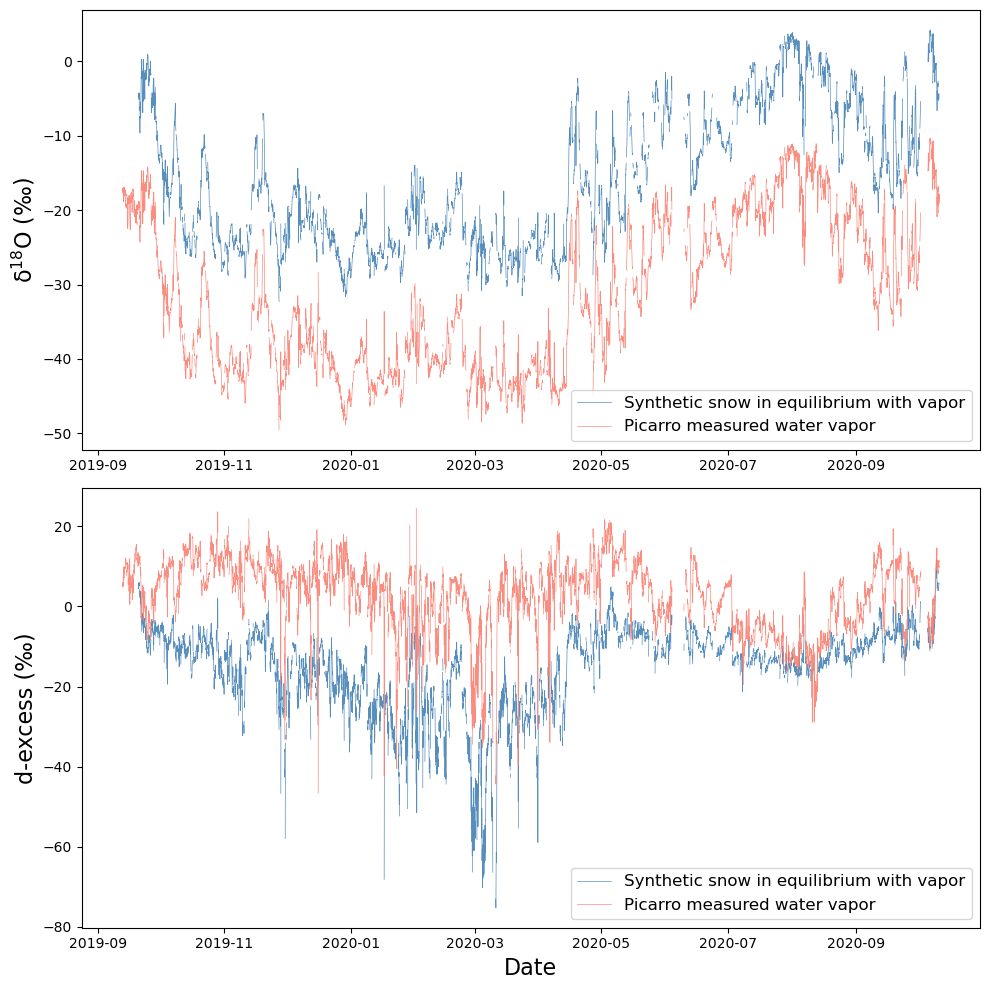

In [35]:
# SYNTHETIC SNOW GENERATED IN EQUILIBRIUM condensation FROM MEASURED VAPOR
################################################################################

delta18O_vap = picarro_dataset['d18O']
deltaD_vap = picarro_dataset['dHDO']
air_temp = mto_dataset['temperature']

delta18O_snow = []
deltaD_snow = []
synthetic_snow = pd.DataFrame()

for index, temp in enumerate(air_temp):
    
    alpha_equilib_18O = np.exp((11.839)/(temp+273.15) - (28.224*10**(-3)))
    alpha_equilib_D = np.exp((16288.0)/(temp+273.15)**2 - (9.34*10**(-2)))
    
    Si = 1 - 0.002 * temp
    Si = 0.05 + 0.906**(-0.008 * temp)
    Si = 0.99 - 0.006 * temp
            
    alpha_kinetic_18O = Si / ((alpha_equilib_18O)*(0.9723/0.9755)*(Si-1)+1)
    alpha_kinetic_D = Si / ((alpha_equilib_D)*(0.9723/0.9755)*(Si-1)+1)
    
    R18O_vap = (delta18O_vap[index]/1000 +1)*R18O_vsmow
    R18O_snow = R18O_vap*(alpha_equilib_18O*alpha_kinetic_18O)
    delta18O_snow.append((R18O_snow/R18O_vsmow -1)*1000)
    
    RD_vap = (deltaD_vap[index]/1000 +1)*RD_vsmow
    RD_snow = RD_vap*(alpha_equilib_D*alpha_kinetic_D)
    deltaD_snow.append((RD_snow/RD_vsmow -1)*1000)
    
synthetic_snow['Time'] = picarro_dataset.index
synthetic_snow['d18O'] = delta18O_snow
synthetic_snow['dD'] = deltaD_snow
synthetic_snow['d-excess'] = synthetic_snow['dD'] - 8 * synthetic_snow['d18O']
synthetic_snow.set_index('Time', inplace=True)


# PLOT SYNTHETIC SNOW GENERATED IN EQUILIBRIUM BY condensation FROM MEASURED VAPOR + MEASURED VAPOUR
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

axes[0].plot(synthetic_snow.index, synthetic_snow['d18O'], linestyle='-', label='Synthetic snow in equilibrium with vapor', color='steelblue', alpha=0.9, linewidth=0.5)
axes[0].plot(picarro_dataset.index, picarro_dataset['d18O'], linestyle='-', label='Picarro measured water vapor', color='salmon', alpha=0.9, linewidth=0.5)
axes[0].set_ylabel("δ$^{18}$O (‰)", fontsize=16)
#axes[0].set_xlabel('Date', fontsize=16)
axes[0].legend(loc='best', fontsize=12)


axes[1].plot(synthetic_snow.index, synthetic_snow['d-excess'], linestyle='-', label='Synthetic snow in equilibrium with vapor', color='steelblue', alpha=0.9, linewidth=0.5)
axes[1].plot(picarro_dataset.index, picarro_dataset['d-excess'], linestyle='-', label='Picarro measured water vapor', color='salmon', alpha=0.9, linewidth=0.5)
axes[1].set_ylabel("d-excess (‰)", fontsize=16)
axes[1].set_xlabel('Date', fontsize=16)
axes[1].legend(loc='best', fontsize=12)

plt.tight_layout()

plt.savefig('C:/CiASOM/PhD/07.Manuscripts/#2.Snow Surface/TS Vapour and Snow/Camilla/Vapour_mes_Snow_syn.jpg', dpi=300)

plt.show()

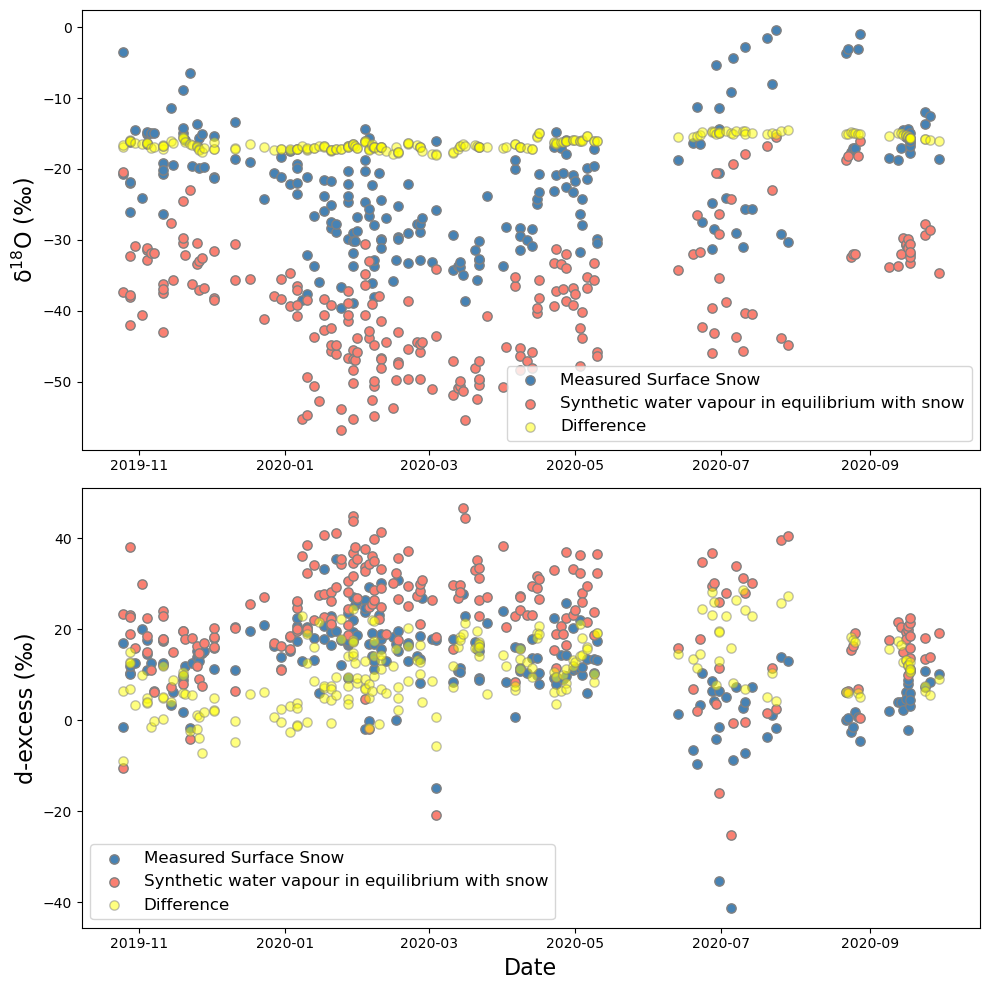

In [36]:
# SYNTHETIC VAPOR GENERATED IN EQUILIBRIUM BY sublimation FROM MEASURED SNOW
#########################################################################################

dfs = pd.read_csv('C:/CiASOM/PhD/07.Manuscripts/#2.Snow Surface/TS Vapour and Snow/Snow_Surface.csv', index_col=0, parse_dates=True, encoding='latin1')
dfs['Time'] = dfs.index

delta18O_snow = dfs['d18O']
deltaD_snow = dfs['dD']
air_temp = dfs['Air_Temp']

delta18O_vap = []
deltaD_vap = []
synthetic_vapor = pd.DataFrame()

for index, temp in enumerate(air_temp):
    alpha_equilib_18O = np.exp((11.839)/(temp+273.15) - (28.224*10**(-3)))
    alpha_equilib_D = np.exp((16288.0)/(temp+273.15)**2 - (9.34*10**(-2)))

    Si = 1 - 0.002 * temp
    Si = 0.05 + 0.906**(-0.008 * temp)
    Si = 0.99 - 0.006 * temp

    alpha_kinetic_18O = Si / ((alpha_equilib_18O) * (0.9723/0.9755) * (Si-1) + 1)
    alpha_kinetic_D = Si / ((alpha_equilib_D) * (0.9723/0.9755) * (Si-1) + 1)

    R18O_snow = (delta18O_snow[index]/1000 + 1) * R18O_vsmow
    R18O_vap = R18O_snow / (alpha_equilib_18O * alpha_kinetic_18O)
    delta18O_vap.append((R18O_vap/R18O_vsmow - 1) * 1000)

    RD_snow = (deltaD_snow[index]/1000 + 1) * RD_vsmow
    RD_vap = RD_snow / (alpha_equilib_D * alpha_kinetic_18O)
    deltaD_vap.append((RD_vap/RD_vsmow - 1) * 1000)

synthetic_vapor['Time'] = dfs.index
synthetic_vapor['d18O'] = delta18O_vap
synthetic_vapor['dD'] = deltaD_vap
synthetic_vapor['d-excess'] = np.array(deltaD_vap) - 8 * np.array(delta18O_vap)
synthetic_vapor.set_index(synthetic_vapor['Time'])

# Reset indices of the dataframes
dfs.reset_index(drop=True, inplace=True)
synthetic_vapor.reset_index(drop=True, inplace=True)

# Calculate the difference between the two datasets
diff_d18O = synthetic_vapor['d18O'] - dfs['d18O']
diff_dexcess = synthetic_vapor['d-excess'] - dfs['d_excess']

# PLOT SYNTHETIC VAPOR GENERATED IN EQUILIBRIUM BY sublimation FROM MEASURED SNOW
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

axes[0].scatter(dfs['Time'], dfs['d18O'], label='Measured Surface Snow', color='steelblue', s=45, edgecolor='grey')
axes[0].scatter(synthetic_vapor['Time'], synthetic_vapor['d18O'], label='Synthetic water vapour in equilibrium with snow', color='salmon', s=45, edgecolor='grey')
axes[0].scatter(dfs['Time'], diff_d18O, label='Difference', color='yellow', s=45, edgecolor='grey', alpha=0.5)
axes[0].set_ylabel("δ$^{18}$O (‰)", fontsize=16)
#axes[0].set_xlabel('Date', fontsize=16)
axes[0].legend(loc='best', fontsize=12)

axes[1].scatter(dfs['Time'], dfs['d_excess'], label='Measured Surface Snow', color='steelblue', s=45, edgecolor='grey')
axes[1].scatter(synthetic_vapor['Time'], synthetic_vapor['d-excess'], label='Synthetic water vapour in equilibrium with snow', color='salmon', s=45, edgecolor='grey')
axes[1].scatter(dfs['Time'], diff_dexcess, label='Difference', color='yellow', s=45, edgecolor='grey', alpha=0.5)
axes[1].set_ylabel("d-excess (‰)", fontsize=16)
axes[1].set_xlabel('Date', fontsize=16)
axes[1].legend(loc='best', fontsize=12)

plt.tight_layout()

plt.savefig('C:/CiASOM/PhD/07.Manuscripts/#2.Snow Surface/TS Vapour and Snow/Camilla/Snow_mes_Vapour_syn_Dif.jpg', dpi=300)

plt.show()

In [12]:
synthetic_vapor.to_csv('C://CiASOM//PhD//07.Manuscripts//#2.Snow Surface//TS Vapour and Snow//Camilla//synthetic_vapor_majoube71.csv')
synthetic_snow.to_csv('C://CiASOM//PhD//07.Manuscripts//#2.Snow Surface//TS Vapour and Snow//Camilla//synthetic_snow_majoube71.csv')

In [14]:
synthetic_snow.head()

,Time,d18O,dD,d-excess
Time,,,,
2019-09-01 00:00:00,2019-09-01 00:00:00,NaN,NaN,NaN
2019-09-01 01:00:00,2019-09-01 01:00:00,NaN,NaN,NaN
2019-09-01 02:00:00,2019-09-01 02:00:00,NaN,NaN,NaN
2019-09-01 03:00:00,2019-09-01 03:00:00,NaN,NaN,NaN
2019-09-01 04:00:00,2019-09-01 04:00:00,NaN,NaN,NaN
